In [ ]:
import os
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as T
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
from transformers import AutoImageProcessor, DeiTForImageClassification
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,ConfusionMatrixDisplay,classification_report

In [ ]:
## To manipulate data.
def sort_list(lst,isImage:bool=True):
  """
  Sort given list
  isImage used to check for images list or json list is given.
  """
  if not isImage:
    s = 5
  else:
    s = 4
  new_lst = []
  extensions = {}
  for i in range(0,len(lst)):
    id = Path(lst[i]).stem
    extensions[id] = lst[i][-s:]
    new_lst.append(int(id))

  new_lst = sorted(new_lst)

  for i in range(0,len(lst)):
    id = str(new_lst[i])
    new_lst[i]= id + extensions[id]
  return new_lst

def create_list(dir,isImage=True,sort=False,fullPath=False):
  """
  Create list given directory.
  """
  lst = os.listdir(dir)

  if sort:
    lst = sort_list(lst,isImage)

  if fullPath:
    for i,img in enumerate(lst):
      path = os.path.join(dir,img)
      lst[i] = path

  return lst

def display_images_labels(imgs_lst,image_label_dictionary):
  """
  Return dataframe contains images and corresponding labels.
  """
  return pd.DataFrame({
      "Image" : [img for img in imgs_lst],
      "Label" : [image_label_dictionary[img] for img in imgs_lst]
  })

def get_selected_indexes(indexs:list,elements_list:list):
  """
  Get elements from elemnts list given their indexs.
  """
  arr = []
  for idx in indexs:
    arr.append(elements_list[idx])
  return arr

def get_values(keys,dictionary):
  """
  Given  keys, returns values from dictionary.
  """
  arr = []
  for key in keys:
    arr.append(dictionary[key])
  return arr

def create_dict(keys,values):
  """
  Return created dictionary.
  """
  dictionary = {}
  for i,k in enumerate(keys):
    dictionary[k] = values[i]
  return dictionary

def create_img_label_dict(imgs_lst,labels_lst,column_num:int):
  """
  create dictionary with images as keys and excel labels as values.
  Image list must be sorted before call this function.
  For sorting call sort_image_list function before.
  """
  _dict = {}
  for i,img in enumerate(imgs_lst):
    _dict[img] = labels_lst.iloc[i,column_num]
  return _dict

def create_cm(actual_labels,predicted,classes,title="Confusion Matrix"):
  """
  Create Confusion Matrix.
  """
  cm = confusion_matrix(actual_labels, predicted)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  cm_display.plot()
  plt.title(title)
  plt.show()

def calculate_metrics(labels,predictions):
  precision = precision_score(labels,predictions)
  recall = recall_score(labels,predictions)
  accuracy = accuracy_score(labels,predictions)
  return accuracy, precision, recall

def search(arr,start_index,element):
  if element ==-1:
    j=start_index+1
    element = arr[start_index]
  else:
    j=0
  while j<len(arr):
    if element == arr[j]:
      return element
    else:
      j+=1
  return -1

def getNotFoundElements(arr1,arr2):
  not_found= []
  for elm in arr1:
    xx = search(arr2,-1,elm)
    if xx ==-1:
      not_found.append(elm)
  return not_found

def load_image(file_name):
  path = "/content/drive/MyDrive/Ara_proje_dataset/all_images"
  image_path = path + "/" + file_name
  image = Image.open(image_path).convert('RGB')
  return image

In [ ]:
images_dir = "/content/drive/MyDrive/Ara_proje_dataset/all_images"
excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Total_Excel.xlsx"
classes = ("Hatasiz" , "Hatali")

label2id = {}
id2label = {}
id = 0
for cls in classes:
  label2id[cls] = id
  id2label[id] = cls
  id+=1

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("facebook/deit-base-distilled-patch16-224")
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224",
                                                   label2id=label2id,
                                                   id2label=id2label,
                                                   ignore_mismatched_sizes = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
labels = pd.read_excel(excel_path,header=None,keep_default_na=False)
images = create_list(images_dir,sort=True)
img_lbl_dict = create_img_label_dict(images,labels,column_num=1)
print("labels file length =", len(labels))
print("images list length =", len(images))
print("dictionary  length =", len(img_lbl_dict))
display_images_labels(images,img_lbl_dict)

labels file length = 1497
images list length = 1497
dictionary  length = 1497


,Image,Label
0,1.jpg,0
1,2.jpg,1
2,3.jpg,1
3,4.jpg,0
4,5.jpg,1
...,...,...
1492,3554.bmp,1
1493,3555.bmp,0
1494,3556.bmp,0
1495,3557.bmp,0


In [ ]:
class ImageDataset(Dataset):
  def __init__(self, images, img_lbl_dict,transform):
    self.images = images
    self.image_label_dictionary = img_lbl_dict
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    path = "/content/drive/MyDrive/Ara_proje_dataset/all_images/"
    image_path = path + self.images[idx]
    image = Image.open(image_path).convert('RGB')
    label = self.image_label_dictionary[self.images[idx]]
    image = self.transform(image)
    label = torch.tensor(label,dtype=torch.long)
    return image, label

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([T.Resize((224,224)),T.ToTensor(),T.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)])
model = model.to(device)        ## Initialize model
loss_func = nn.CrossEntropyLoss()                           ## loss function
optimizer = optim.Adam(model.parameters(),lr=5e-5)          ## optimizer
#scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
batch_size = 32                                             ## batch size
num_epochs = 10                                             ## Number of epochs
K = 5                                                       ## Number of folds
kf = KFold(n_splits=K)                                      ## Define K-Fold method for cross validation

In [ ]:
def run_epoch(num_epochs,epoch_id,model,device,true_lbls,predicted_lbls,dataloader,is_training):
    acc, lossValue, corrects, count= 0.0, 0.0, 0, 0
    loop = tqdm(dataloader)                                ## Show progress bar for train loop.
    ## Set model mode to train.

    for _, sample in enumerate(loop):                    ## iterate whole train dataset with batches.
      ## Get images and their corresponding labels.
      imgs, labels = sample
      imgs = imgs.to(device)
      labels = labels.to(device)

      if is_training:
        optimizer.zero_grad()                             ## Reset grads to zero.

      outputs = model(imgs).logits                               ## make predictions

      predictions = outputs.argmax(dim=1, keepdim=True).squeeze() ## Get highest probability predicted class for each input sample.
      count += len(predictions)
      corrects += (predictions == labels).sum().item()    ## Count the correct predictions.

      ## Calculate loss value.
      loss = loss_func(outputs,labels)
      if is_training:
        loss.backward()                                   ## Calculate gradiants of the loss.
        optimizer.step()                                  ## Update optimizer parameters.

      lossValue += loss.item()                            ## Get loss value.
      acc = corrects/count
      avg_loss = lossValue/len(dataloader)

      if is_training==False and true_lbls !=None:
        true_lbls.extend(labels.tolist())
        predicted_lbls.extend(predictions.tolist())
      ## Update progress bar.
      if is_training:
        loop.set_description(f"Epoch: [{epoch_id+1}/{num_epochs}]")
      else:
        loop.set_description("Evaluation Step:")
      loop.set_postfix(Avg_Loss= avg_loss, Loss = loss.item(), Accuracy = acc)

    return acc, avg_loss

In [ ]:
## Train loop
losses = []
acc = []
true_lbls = []
predicted_lbls = []
for i, (train_index, test_index) in enumerate(kf.split(images)):
  print(f"Fold {i+1}/{K}")
  ## Get select items for train/test folds.
  x_train = get_selected_indexes(train_index,images)
  x_test  = get_selected_indexes(test_index,images)

  ## Initialize train/test dataset instances.
  train_dataset = ImageDataset(x_train, img_lbl_dict, transform)
  test_dataset = ImageDataset(x_test, img_lbl_dict, transform)
  #print(f"train dataset length: {len(train_dataset)} , test dataset length: {len(test_dataset)}")

  ## Initialize train/test dataloaders.
  train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=2,shuffle=True)
  test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers=2)
  #print(f"Number of batches in train DataLoader: {len(train_dataloader)}, Number of batches in test DataLoader: {len(test_dataloader)}")
  v_acc, v_avg_loss = None, None
  for epoch in range(0,num_epochs):
    ## Set model mode to train.
    model.train()
    _, _ = run_epoch(num_epochs,epoch,model,device,None,None,train_dataloader,True)   ## Run epoch

    ## Set model mode to evaluation.
    ## all steps like above in training mode but for evaluate model on test dataset.
    model.eval()
    with torch.no_grad():
      if epoch==num_epochs-1:
        v_acc, v_avg_loss = run_epoch(None,None,model,device,true_lbls,predicted_lbls,test_dataloader,False)        ## Evaluate model
      else:
        v_acc, v_avg_loss = run_epoch(None,None,model,device,None,None,test_dataloader,False)
    #before_lr = optimizer.param_groups[0]["lr"]
    #scheduler.step()
    #after_lr = optimizer.param_groups[0]["lr"]
    #print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
  ## Store metrics.
  acc.append(v_acc)
  losses.append(v_avg_loss)

Fold 1/5


  0%|          | 0/38 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: [6/10]:  63%|██████▎   | 24/38 [00:54<00:28,  2.01s/it, Accuracy=0.999, Avg_Loss=0.00376, Loss=0.00344]

Model Performance:
Model average loss:0.6490721243123214, Model average Accuracy: 61.8562718205379%
              precision    recall  f1-score   support

     Hatasiz       0.71      0.30      0.42       691
      Hatali       0.60      0.89      0.72       806

    accuracy                           0.62      1497
   macro avg       0.65      0.60      0.57      1497
weighted avg       0.65      0.62      0.58      1497



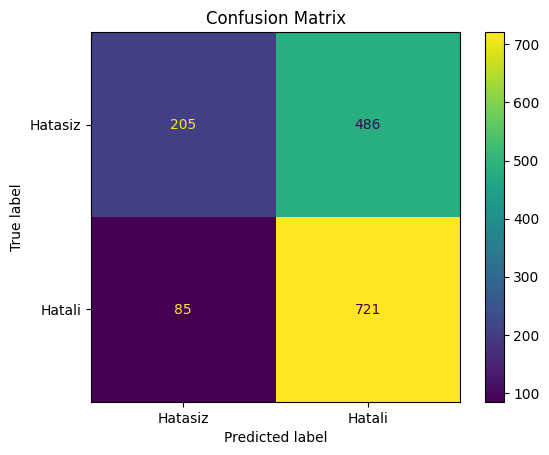

In [ ]:
print("Model Performance:")
print(f"Model average loss:{sum(losses)/len(losses)}, Model average Accuracy: {100*sum(acc)/len(acc)}%")
print(classification_report(true_lbls,predicted_lbls,target_names=classes))
create_cm(true_lbls,predicted_lbls,classes)

In [ ]:
def test_model(dataset,annotation_dict,batch_size,transform):
  test_data = ImageDataset(dataset,annotation_dict,transform)
  test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)
  total_samples = 0
  test_labels = []
  predicted = []
  model.eval()
  with torch.no_grad():
    loop = tqdm(test_loader)
    for i, (imgs, labels) in enumerate(loop):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs).logits
      predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
      total_samples += len(predictions)
      test_labels.extend(labels.tolist())
      predicted.extend(predictions.tolist())
  print(f"Number of samples: {total_samples}")
  return test_labels,predicted

In [ ]:
t, p = test_model(images,img_lbl_dict,batch_size,transform)
m = calculate_metrics(t,p)
print(f"Accuracy: {m[0]}, Precision: {m[1]}, Recall: {m[2]}")
print(classification_report(t,p,target_names=classes))
create_cm(t,p,classes)          ## Draw confusion matrix

In [ ]:
torch.save(model,"/content/drive/MyDrive/Models/DeiTForImageCls_bütün_görüntü.pth")